# IBM Coursera Advanced Data Science Capstone
## Predict the genre of a book based on it's cover image

### Import the libraries which will be used in this project

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20191005113542-0000
KERNEL_ID = ffb012f0-e06f-4c8d-a271-57ec0b4f4a9f


Using TensorFlow backend.


### Access permissions to the relevant data

In [2]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='###', project_access_token='###')
pc = project.project_context


In [3]:
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials = {
    'IAM_SERVICE_ID': '###',
    'IBM_API_KEY_ID': '###',
    'ENDPOINT': '###',
    'IBM_AUTH_ENDPOINT': '###',
    'BUCKET': '###',
    'FILE': 'Dataset.zip'
}

### Get the dataset

In [4]:
import zipfile
def get_zip(file_name):

    try:
        fobj = open(file_name, "wb")
        fobj.write(project.get_file(file_name).read()) 
        fobj.close()
        z = zipfile.ZipFile(file_name)
        z.extractall()
    except Exception as e:
        print(Exception,e)
    else:
        print('Files downloaded successfully') 

In [5]:
get_zip('Dataset.zip')

Files downloaded successfully


### Read the csv file and print the column names

In [6]:
train = pd.read_csv(project.get_file('train.csv'))
train.head()

,Id,genre,CHL-Fiction,Comic,Cooking,Crime,SciFi,Travel
0,9780297608486.jpg,['Crime'],0,0,0,1,0,0
1,9780297608981.jpg,['Cooking'],0,0,1,0,0,0
2,9780297609148.jpg,['Crime'],0,0,0,1,0,0
3,9780297609315.jpg,['Cooking'],0,0,1,0,0,0
4,9780297609803.jpg,['Crime'],0,0,0,1,0,0


In [7]:
train.columns

Index(['Id', 'genre', 'CHL-Fiction', 'Comic', 'Cooking', 'Crime', 'SciFi',
       'Travel'],
      dtype='object')

### Get an idea of the average, minimum and maximum sizes of the book covers

In [8]:
heights = []
widths = []
for i in tqdm(range(train.shape[0])):
     img = image.load_img('Dataset/'+train['Id'][i])  
     img = image.img_to_array(img)
     heights.append(img.shape[0])
     widths.append(img.shape[1])

avg_height = sum(heights) / len(heights)
avg_width = sum(widths) / len(widths)
print("Average Height: " + str(avg_height))
print("Max Height: " + str(max(heights)))
print("Min Height: " + str(min(heights)))
print("Average Width: " + str(avg_width))
print("Max Width: " + str(max(widths)))
print("Min Width: " + str(min(widths)))

100%|██████████| 5730/5730 [01:08<00:00, 83.82it/s] 

Average Height: 651.3284467713787
Max Height: 3000
Min Height: 150
Average Width: 443.7940663176265
Max Width: 2400
Min Width: 98


### Load and preprocess the images

In [9]:
IMG_HEIGHT = min(heights)
#IMG_WIDTH = min(heights)
IMG_WIDTH = min(widths)
#IMG_SIZE = 150

train_image = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img('Dataset/'+train['Id'][i], target_size=(IMG_HEIGHT,IMG_WIDTH,3)) 
    img = image.img_to_array(img)
    img = img.astype('float32') 
    img = img/255 
    train_image.append(img)
  
    
X = np.array(train_image)

100%|██████████| 5730/5730 [01:03<00:00, 89.83it/s] 


### Verify the shape of the array and plot and visualise one of the images

In [10]:
X.shape

(5730, 150, 98, 3)

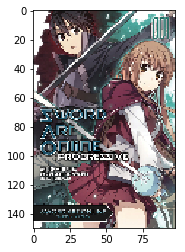

In [11]:
plt.imshow(X[600])

### Print the genre of this book

In [12]:
train['genre'][600]

"['Comic']"

### Remove the Id and genre columns from the train file and convert the remaining columns to an array which will be the target for the images

In [13]:
y = np.array(train.drop(['Id', 'genre'],axis=1))
y.shape

(5730, 6)

### Create a validation set to check the performance of the model on unseen data by separating 10% of the images as the validation set

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

###  Define the architecture of the model. The output layer will have 6 neurons (equal to the number of genres) and will use sigmoid as the activation function.

In [19]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation="relu", input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))

### Print the model summary

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 96, 16)       448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 48, 16)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 74, 48, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 46, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 23, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 36, 23, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 21, 64)        18496     
__________

### Compile the model

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Train the model. The model will be trained for 10 epochs and also pass the validation data which was created earlier in order to validate the model’s performance:

In [22]:
hist = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=64)

Instructions for updating:
Use tf.cast instead.


Train on 5157 samples, validate on 573 samples
Epoch 1/10
5157/5157 [==============================] - 20s 4ms/step - loss: 0.5040 - acc: 0.8111 - val_loss: 0.5283 - val_acc: 0.8333
Epoch 2/10
5157/5157 [==============================] - 17s 3ms/step - loss: 0.4702 - acc: 0.8323 - val_loss: 0.4684 - val_acc: 0.8333
Epoch 3/10
5157/5157 [==============================] - 17s 3ms/step - loss: 0.4512 - acc: 0.8329 - val_loss: 0.4337 - val_acc: 0.8345
Epoch 4/10
5157/5157 [==============================] - 17s 3ms/step - loss: 0.4317 - acc: 0.8357 - val_loss: 0.4099 - val_acc: 0.8458
Epoch 5/10
5157/5157 [==============================] - 17s 3ms/step - loss: 0.4170 - acc: 0.8410 - val_loss: 0.3923 - val_acc: 0.8499
Epoch 6/10
5157/5157 [==============================] - 17s 3ms/step - loss: 0.3975 - acc: 0.8439 - val_loss: 0.3744 - val_acc: 0.8508
Epoch 7/10
5157/5157 [==============================] - 17s 3ms/step - loss: 0.3796 - acc: 0.8481 - val_loss: 0.3562 - val_acc: 0.8589
Epoch 8/

### Get the model's accuracy on the test data.

In [23]:
model.evaluate(X_test, y_test)[1]

573/573 [==============================] - 0s 756us/step


0.864456103838343

### Visualize the model's accuracy

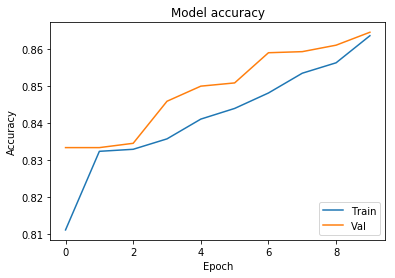

In [24]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

### Visualize the model's loss

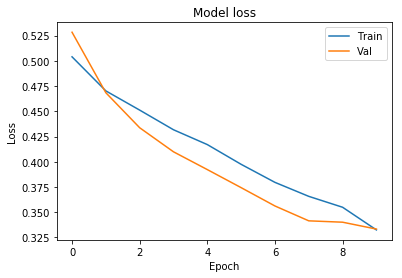

In [25]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Make predictions on unseen images.
#### This is SciFi according to the publisher's classification

Crime (0.508)
SciFi (0.4)
CHL-Fiction (0.102)


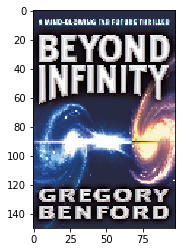

In [26]:
img = image.load_img('Dataset/9781841491882.jpg',target_size=(IMG_HEIGHT,IMG_WIDTH,3))
img = image.img_to_array(img)
img = img/255

classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1,IMG_HEIGHT,IMG_WIDTH,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

#### This is a Travel book according to the publisher's classification

Travel (0.712)
SciFi (0.115)
Crime (0.0787)


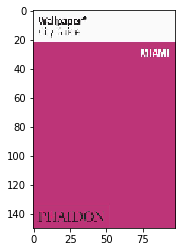

In [27]:
img = image.load_img('Dataset/9780714860930.jpg',target_size=(IMG_HEIGHT,IMG_WIDTH,3))
img = image.img_to_array(img)
img = img/255

classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1,IMG_HEIGHT,IMG_WIDTH,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

#### This is a Comic according to the publisher's classification

Comic (0.678)
SciFi (0.13)
CHL-Fiction (0.128)


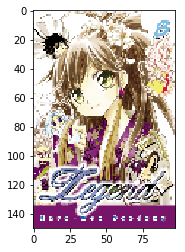

In [28]:
img = image.load_img('Dataset/9780759531390.jpg',target_size=(IMG_HEIGHT,IMG_WIDTH,3))
img = image.img_to_array(img)
img = img/255

classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1,IMG_HEIGHT,IMG_WIDTH,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

#### This is Children Fiction according to the publisher's classification

Cooking (0.457)
CHL-Fiction (0.342)
Comic (0.103)


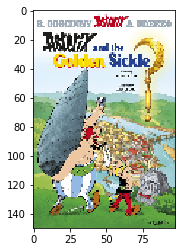

In [29]:
img = image.load_img('Dataset/9780752866130.jpg',target_size=(IMG_HEIGHT,IMG_WIDTH,3))
img = image.img_to_array(img)
img = img/255

classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1,IMG_HEIGHT,IMG_WIDTH,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

#### This is Crime according to the publisher's classification

Crime (0.449)
SciFi (0.423)
CHL-Fiction (0.105)


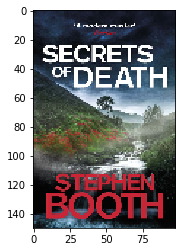

In [30]:
img = image.load_img('Dataset/9780751560008.jpg',target_size=(IMG_HEIGHT,IMG_WIDTH,3))
img = image.img_to_array(img)
img = img/255

classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1,IMG_HEIGHT,IMG_WIDTH,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

#### This is a Cook Book according to the publisher's classification

Cooking (0.476)
CHL-Fiction (0.241)
Travel (0.16)


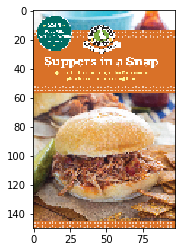

In [31]:
img = image.load_img('Dataset/9781620932889.jpg',target_size=(IMG_HEIGHT,IMG_WIDTH,3))
img = image.img_to_array(img)
img = img/255

classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1,IMG_HEIGHT,IMG_WIDTH,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

#### Save the model.
#### To load it:
from keras.models import load_model  
model = load_model('model_150.h5')

In [32]:
model.save('model_150.h5')